# Installation Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
import pypfopt
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [51]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import StockPortfolioEnv
from scipy.optimize import minimize
import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

# Load Data

In [5]:
df_merged = pd.read_csv('data/merged.csv')
stock_dimension = len(df_merged.tic.unique())
df_merged

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,ORCL,10104,2007-01-03,-0.168,1,XLK,17.510,0.010,0.015,-0.022,-0.026,17.220,17.780,17.100,14.514,52241700,2,0.000,14.783,14.385,100.000,66.667,100.000,14.514,14.514,0.000
1,ORCL,10104,2007-01-04,0.046,1,XLK,17.680,-0.002,-0.016,-0.023,-0.015,17.550,17.870,17.300,14.654,33559800,3,0.003,14.783,14.385,100.000,66.667,100.000,14.584,14.584,0.000
2,ORCL,10104,2007-01-05,-0.210,1,XLK,17.640,0.012,-0.008,-0.036,-0.027,17.620,17.760,17.440,14.621,36154800,4,0.003,14.744,14.449,80.425,49.450,100.000,14.596,14.596,0.000
3,ORCL,10104,2007-01-08,-0.142,1,XLK,17.860,-0.002,-0.031,-0.041,-0.047,17.630,17.930,17.450,14.804,31018100,0,0.009,14.888,14.409,90.740,122.246,100.000,14.648,14.648,0.000
4,ORCL,10104,2007-01-09,-0.102,1,XLK,17.820,-0.003,-0.017,-0.038,-0.051,17.930,17.980,17.650,14.770,31417000,1,0.011,14.907,14.438,82.556,107.926,100.000,14.673,14.673,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,FSLR,91611,2021-12-27,-0.259,2,XLK,87.860,-0.006,0.008,-0.041,-0.136,88.000,88.000,85.900,87.860,730700,0,-4.901,108.006,83.714,39.371,-128.157,32.102,99.672,103.856,0.041
41543,FSLR,91611,2021-12-28,0.013,2,XLK,87.350,-0.002,-0.001,-0.033,-0.126,88.250,88.700,87.080,87.350,560300,1,-4.892,106.433,83.337,39.019,-114.364,28.501,98.886,103.703,0.038
41544,FSLR,91611,2021-12-29,-0.104,2,XLK,87.180,0.010,-0.042,-0.035,-0.172,87.160,88.140,85.970,87.180,795300,2,-4.843,105.334,82.794,38.899,-112.652,31.659,98.049,103.572,0.004
41545,FSLR,91611,2021-12-30,0.049,2,XLK,88.040,-0.010,-0.046,-0.060,-0.166,87.760,89.290,87.400,88.040,837400,3,-4.680,104.367,82.401,39.866,-93.985,25.520,97.500,103.446,0.119


# Weight Initialization
## Retail Weights (Rank-based method)

In [6]:
# Compute a set of weights for asset allocation
df_merged['moribvol'] = df_merged.groupby(['date'])['moribvol'].rank(method='dense')
df_merged['moribvol'] = df_merged.groupby('date')['moribvol'].apply(lambda x: x/x.sum())

df_merged['fake_macd'] = np.random.normal(df_merged['macd'].mean(), df_merged['macd'].std(), size=len(df_merged['macd'])) 
df_merged['fake_rsi_30'] = np.random.normal(df_merged['rsi_30'].mean(), df_merged['cci_30'].std(), size=len(df_merged['dx_30'])) 
df_merged['fake_cci_30'] = np.random.normal(df_merged['cci_30'].mean(), df_merged['cci_30'].std(), size=len(df_merged['cci_30'])) 
df_merged['fake_dx_30'] = np.random.normal(df_merged['dx_30'].mean(), df_merged['dx_30'].std(), size=len(df_merged['dx_30'])) 

df_merged 

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30
0,ORCL,10104,2007-01-03,0.045,1,XLK,17.510,0.010,0.015,-0.022,-0.026,17.220,17.780,17.100,14.514,52241700,2,0.000,14.783,14.385,100.000,66.667,100.000,14.514,14.514,0.000,-0.300,130.945,31.785,19.166
1,ORCL,10104,2007-01-04,0.091,1,XLK,17.680,-0.002,-0.016,-0.023,-0.015,17.550,17.870,17.300,14.654,33559800,3,0.003,14.783,14.385,100.000,66.667,100.000,14.584,14.584,0.000,-2.486,24.655,124.787,16.537
2,ORCL,10104,2007-01-05,0.015,1,XLK,17.640,0.012,-0.008,-0.036,-0.027,17.620,17.760,17.440,14.621,36154800,4,0.003,14.744,14.449,80.425,49.450,100.000,14.596,14.596,0.000,-2.853,253.412,-45.146,-10.700
3,ORCL,10104,2007-01-08,0.076,1,XLK,17.860,-0.002,-0.031,-0.041,-0.047,17.630,17.930,17.450,14.804,31018100,0,0.009,14.888,14.409,90.740,122.246,100.000,14.648,14.648,0.000,-0.318,-50.681,-37.351,29.101
4,ORCL,10104,2007-01-09,0.045,1,XLK,17.820,-0.003,-0.017,-0.038,-0.051,17.930,17.980,17.650,14.770,31417000,1,0.011,14.907,14.438,82.556,107.926,100.000,14.673,14.673,0.000,1.389,-2.025,-80.118,26.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,FSLR,91611,2021-12-27,0.015,2,XLK,87.860,-0.006,0.008,-0.041,-0.136,88.000,88.000,85.900,87.860,730700,0,-4.901,108.006,83.714,39.371,-128.157,32.102,99.672,103.856,0.041,-2.701,122.597,205.200,54.147
41543,FSLR,91611,2021-12-28,0.076,2,XLK,87.350,-0.002,-0.001,-0.033,-0.126,88.250,88.700,87.080,87.350,560300,1,-4.892,106.433,83.337,39.019,-114.364,28.501,98.886,103.703,0.038,2.589,88.787,234.731,1.207
41544,FSLR,91611,2021-12-29,0.015,2,XLK,87.180,0.010,-0.042,-0.035,-0.172,87.160,88.140,85.970,87.180,795300,2,-4.843,105.334,82.794,38.899,-112.652,31.659,98.049,103.572,0.004,-2.331,104.599,-121.713,34.351
41545,FSLR,91611,2021-12-30,0.152,2,XLK,88.040,-0.010,-0.046,-0.060,-0.166,87.760,89.290,87.400,88.040,837400,3,-4.680,104.367,82.401,39.866,-93.985,25.520,97.500,103.446,0.119,-4.838,47.342,-134.603,10.689


## Equal Weights

In [7]:
df_merged['equal'] = 1/stock_dimension

## Mean-Variance Optimization Weights

In [ ]:
"""
def constrainedMV(cov_matrix):
    d = cov_matrix.shape[0]
    def objective(w, cov_matrix):
        return np.dot(w.T, np.dot(cov_matrix, w))
    initial_weight = np.abs(np.random.randn(d))
    x0 = np.ones(d) / d
    constraints = [{'type': 'eq', 'fun': lambda x:np.sum(x)-1}]
    result = minimize(lambda x:np.dot(x.T, np.dot(cov_matrix, x)), x0, constraints=constraints)
    a = np.array(result.x)
    return a
"""

In [104]:
def rolling_windows(df,current_date,duration = 100):
    loc = df.index.get_loc(current_date)
    return df.iloc[loc - duration :loc + 1,:]

def prepare_df(df):
    used_df = df[['tic','date','ret_1']]
    df_pivot = used_df.pivot(index='date', columns='tic', values='ret_1').shift(1).iloc[1:,:]
    #use shift one because ret1 is the return on the next date.
    return df_pivot

def initialize_weight(df,rolling_length,short_sale = True):
    df = prepare_df(df)
    weight = pd.DataFrame(np.nan, index=df.index, columns=df.columns)
    d = len(df.iloc[0])
    for current_date in df.index:
        #if not sufficient data: return equal weight
        if df.index.get_loc(current_date) < rolling_length:
            weight.loc[current_date] = 1/len(df.iloc[0,:])
        #if sufficient data: return minimum variance portfolio weight
        else:
            cov = rolling_windows(df,current_date,rolling_length).cov().to_numpy()
            if short_sale == False:
                ef = pypfopt.EfficientFrontier(np.ones(d),cov)
                current_weight = list(ef.min_volatility().values())
                weight.loc[current_date] = current_weight
            else:
                cov_inv = np.linalg.inv(cov)
                date_weight = cov_inv @ np.ones(d)
                date_weight = date_weight / np.sum(date_weight)
                weight.loc[current_date] = date_weight
    return weight

mean_var_weight_df = initialize_weight(df_merged,100,False)
mean_var_weight_df.loc['2007-01-03'] = np.ones(11)/11
mean_var_weight_df = mean_var_weight_df.sort_index()

In [105]:
mean_var_weight_df #first 100 days are set to be equally distributed as there's not enough data for training

tic,ADSK,AMD,CSCO,FSLR,INTU,LRCX,MSFT,ORCL,QCOM,TXN,WU
date,,,,,,,,,,,
2007-01-03,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091
2007-01-04,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091
2007-01-05,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091
2007-01-08,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091
2007-01-09,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.000,0.000,0.249,0.075,0.000,0.000,0.199,0.000,0.061,0.201,0.215
2021-12-28,0.000,0.000,0.251,0.076,0.000,0.000,0.202,0.000,0.064,0.188,0.220
2021-12-29,0.000,0.000,0.249,0.075,0.000,0.000,0.205,0.000,0.061,0.190,0.220


In [113]:
df_merged['mean-var'] = mean_var_weight_df.melt()['value']

In [114]:
#TODO: Compute and append mean variance weights to "df_merged" here, say column name as "mean-var"
df_merged

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,equal,mean-var
0,ORCL,10104,2007-01-03,0.045,1,XLK,17.510,0.010,0.015,-0.022,-0.026,17.220,17.780,17.100,14.514,52241700,2,0.000,14.783,14.385,100.000,66.667,100.000,14.514,14.514,0.000,-0.300,130.945,31.785,19.166,0.091,0.091
1,ORCL,10104,2007-01-04,0.091,1,XLK,17.680,-0.002,-0.016,-0.023,-0.015,17.550,17.870,17.300,14.654,33559800,3,0.003,14.783,14.385,100.000,66.667,100.000,14.584,14.584,0.000,-2.486,24.655,124.787,16.537,0.091,0.091
2,ORCL,10104,2007-01-05,0.015,1,XLK,17.640,0.012,-0.008,-0.036,-0.027,17.620,17.760,17.440,14.621,36154800,4,0.003,14.744,14.449,80.425,49.450,100.000,14.596,14.596,0.000,-2.853,253.412,-45.146,-10.700,0.091,0.091
3,ORCL,10104,2007-01-08,0.076,1,XLK,17.860,-0.002,-0.031,-0.041,-0.047,17.630,17.930,17.450,14.804,31018100,0,0.009,14.888,14.409,90.740,122.246,100.000,14.648,14.648,0.000,-0.318,-50.681,-37.351,29.101,0.091,0.091
4,ORCL,10104,2007-01-09,0.045,1,XLK,17.820,-0.003,-0.017,-0.038,-0.051,17.930,17.980,17.650,14.770,31417000,1,0.011,14.907,14.438,82.556,107.926,100.000,14.673,14.673,0.000,1.389,-2.025,-80.118,26.031,0.091,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,FSLR,91611,2021-12-27,0.015,2,XLK,87.860,-0.006,0.008,-0.041,-0.136,88.000,88.000,85.900,87.860,730700,0,-4.901,108.006,83.714,39.371,-128.157,32.102,99.672,103.856,0.041,-2.701,122.597,205.200,54.147,0.091,0.215
41543,FSLR,91611,2021-12-28,0.076,2,XLK,87.350,-0.002,-0.001,-0.033,-0.126,88.250,88.700,87.080,87.350,560300,1,-4.892,106.433,83.337,39.019,-114.364,28.501,98.886,103.703,0.038,2.589,88.787,234.731,1.207,0.091,0.220
41544,FSLR,91611,2021-12-29,0.015,2,XLK,87.180,0.010,-0.042,-0.035,-0.172,87.160,88.140,85.970,87.180,795300,2,-4.843,105.334,82.794,38.899,-112.652,31.659,98.049,103.572,0.004,-2.331,104.599,-121.713,34.351,0.091,0.220
41545,FSLR,91611,2021-12-30,0.152,2,XLK,88.040,-0.010,-0.046,-0.060,-0.166,87.760,89.290,87.400,88.040,837400,3,-4.680,104.367,82.401,39.866,-93.985,25.520,97.500,103.446,0.119,-4.838,47.342,-134.603,10.689,0.091,0.224


## Data Split

In [29]:
START_DATE = '2007-01-03'
MID_DATE = '2018-01-02'
END_DATE = '2022-01-01'

tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fake_tech_indicator_list = ['fake_macd', 'fake_rsi_30', 'fake_cci_30', 'fake_dx_30']
weights = ['moribvol', 'equal']

states = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
states += fake_tech_indicator_list + weights

train_data = data_split(df_merged[states], START_DATE, MID_DATE)
trade_data = data_split(df_merged[states], MID_DATE, END_DATE)
data = data_split(df_merged[states], START_DATE, END_DATE)

In [30]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal
0,2007-01-03,40.630,41.830,39.810,40.560,3873900,ADSK,2,0.000,42.034,39.856,100.000,66.667,100.000,40.560,40.560,-1.495,188.432,-24.018,9.889,0.136,0.091
0,2007-01-03,20.080,20.400,19.350,19.520,28350300,AMD,2,0.000,20.037,19.273,100.000,-66.667,100.000,19.520,19.520,1.164,258.488,-12.112,23.279,0.061,0.091
0,2007-01-03,27.460,27.980,27.330,19.536,64226000,CSCO,2,0.000,20.520,19.066,100.000,66.667,100.000,19.536,19.536,-3.028,234.352,96.051,10.989,0.015,0.091
0,2007-01-03,30.170,30.290,28.200,28.500,487000,FSLR,2,0.000,28.979,28.271,100.000,-66.667,100.000,28.500,28.500,-6.141,241.432,-19.203,17.003,0.152,0.091
0,2007-01-03,30.680,31.060,29.100,26.496,4734600,INTU,2,0.000,27.201,26.159,100.000,-66.667,100.000,26.496,26.496,2.663,-20.901,144.368,21.552,0.121,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-29,85.630,86.050,85.500,80.353,18717400,MSFT,4,0.755,82.580,76.658,60.144,74.372,15.450,79.209,77.226,7.504,181.526,-70.879,21.943,0.136,0.091
2768,2017-12-29,47.530,47.880,47.280,43.361,9750000,ORCL,4,-0.469,46.547,42.377,42.781,-104.196,16.192,44.585,44.987,3.777,76.235,89.062,22.491,0.015,0.091
2768,2017-12-29,64.360,64.650,64.000,55.318,6631800,QCOM,4,0.254,56.595,55.253,56.700,-86.758,5.702,56.536,52.515,3.266,-136.879,239.818,12.959,0.045,0.091
2768,2017-12-29,104.580,105.080,104.420,90.749,2813300,TXN,4,1.784,93.422,81.992,68.523,122.502,47.232,86.948,84.777,-0.428,79.702,-142.771,34.583,0.121,0.091


In [31]:
trade_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal
0,2018-01-02,105.340,107.160,104.390,107.120,2040600,ADSK,1,-3.126,109.299,103.069,42.401,-46.823,16.989,111.624,116.601,-0.317,40.275,59.437,27.454,0.121,0.091
0,2018-01-02,10.420,11.020,10.340,10.980,44146300,AMD,1,-0.118,11.174,9.591,47.857,16.873,1.262,10.656,11.574,-1.141,33.260,122.589,45.909,0.076,0.091
0,2018-01-02,38.670,38.950,38.430,33.136,20135700,CSCO,1,0.546,33.333,31.723,68.414,104.513,41.566,32.173,30.622,0.039,143.439,23.076,9.636,0.030,0.091
0,2018-01-02,67.840,70.500,67.840,70.430,1752200,FSLR,1,2.129,74.356,61.051,63.063,70.593,22.722,65.429,59.588,6.056,80.774,-83.255,-18.558,0.061,0.091
0,2018-01-02,158.220,158.850,157.010,152.836,1436100,INTU,1,1.228,155.434,147.894,59.470,59.491,11.443,150.864,147.513,-1.220,81.394,96.172,0.601,0.152,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,2021-12-31,338.510,339.360,335.850,332.365,18000800,MSFT,4,2.333,343.209,315.177,55.069,41.028,10.666,330.022,322.471,1.605,72.633,-72.540,9.854,0.152,0.091
1007,2021-12-31,88.050,88.100,87.180,85.402,5908200,ORCL,4,-1.536,102.358,79.414,43.416,-97.508,15.966,90.801,92.164,1.749,-49.570,-41.914,14.432,0.030,0.091
1007,2021-12-31,183.310,185.150,182.600,177.918,4113300,QCOM,4,3.541,184.097,169.783,59.872,46.197,34.435,176.387,157.506,1.423,50.452,-45.142,51.709,0.076,0.091
1007,2021-12-31,189.410,190.000,188.270,181.990,2813900,TXN,4,-0.804,192.027,176.924,47.910,-71.323,5.853,185.032,185.000,-1.154,-133.316,53.524,30.066,0.136,0.091


In [32]:
# Last, save both train and trade dfs to csv in data foler
train_data.to_csv('data/train_data.csv', index=True)  
trade_data.to_csv('data/trade_data.csv', index=True) 

# Benchmarks
We compare the performance of different weighting methods on the train period
 - Mean Variance
 - Equally weighted (Buy and hold)
 - Market indexes (NASDAQ and XLK)
 - Individual stocks

## Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [33]:
state_space = stock_dimension
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train_data, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade_data, **env_kwargs)
env = StockPortfolioEnv.StockPortfolioEnv(df = data, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


## Sampling

In [34]:
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data['moribvol'])
retail_trade = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data['moribvol'])

begin_total_asset:1000000
end_total_asset:4904419.075973194
Sharpe:  0.6730985319353748
begin_total_asset:1000000
end_total_asset:3226196.7258413886
Sharpe:  1.17540376465224


In [35]:
retail = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=data['moribvol'])
retail_asset_memory = env.asset_memory

begin_total_asset:1000000
end_total_asset:16124738.321794564
Sharpe:  0.8168309700105183


In [36]:
equal = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=data['equal'])
equal_asset_memory = env.asset_memory

begin_total_asset:1000000
end_total_asset:12542027.586077316
Sharpe:  0.7823684922755829


In [37]:
# TODO: to be changed to excecute like the above function

# # Mean variance
# mean_var_df = pd.read_csv('data/mean_var_weight.csv')
# mean_var_df = pd.concat([mean_var_df.iloc[[0]], mean_var_df], ignore_index=True)
# mean_var_df = pd.concat([mean_var_df, mean_var_df.iloc[[len(mean_var_df)-1]]], ignore_index=True)
# mean_var_df.loc[0, 'date'] = '2007-01-03'
# mean_var_df.loc[len(mean_var_df)-1, 'date'] = '2017-12-29'
# mean_var_df = mean_var_df.drop(mean_var_df.columns[0], axis=1)

# mean_var_dataset = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=mean_var_df.values)
# mean_var_cum_ret = pd.DataFrame({'ret': 1000000 + np.insert(mean_var_dataset['rewards'].cumsum(), 0, 0, axis=0)})
# mean_var_cum_ret['ret'] /= 1000000

In [38]:
# XLK
yf_xlk = YahooDownloader(start_date = START_DATE, end_date = END_DATE, ticker_list = ["XLK"]).fetch_data()

yf_xlk = fe.preprocess_data(yf_xlk)
yf_xlk['ret'] = yf_xlk['open']/ yf_xlk['open'].loc[0]
yf_xlk = yf_xlk.fillna(0)
yf_xlk = yf_xlk.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3777, 8)
Successfully added technical indicators
Successfully added turbulence index


In [39]:
# individual stocks
grouped = df_merged.groupby('tic')
selected_cum_ret = grouped.apply(lambda x: x['open']/x['open'].iloc[0])
selected_cum_ret = selected_cum_ret.reset_index()
selected_cum_ret = selected_cum_ret.set_index('level_1')
selected_cum_ret = selected_cum_ret.join(df_merged[['date']])

## Performance Comparison

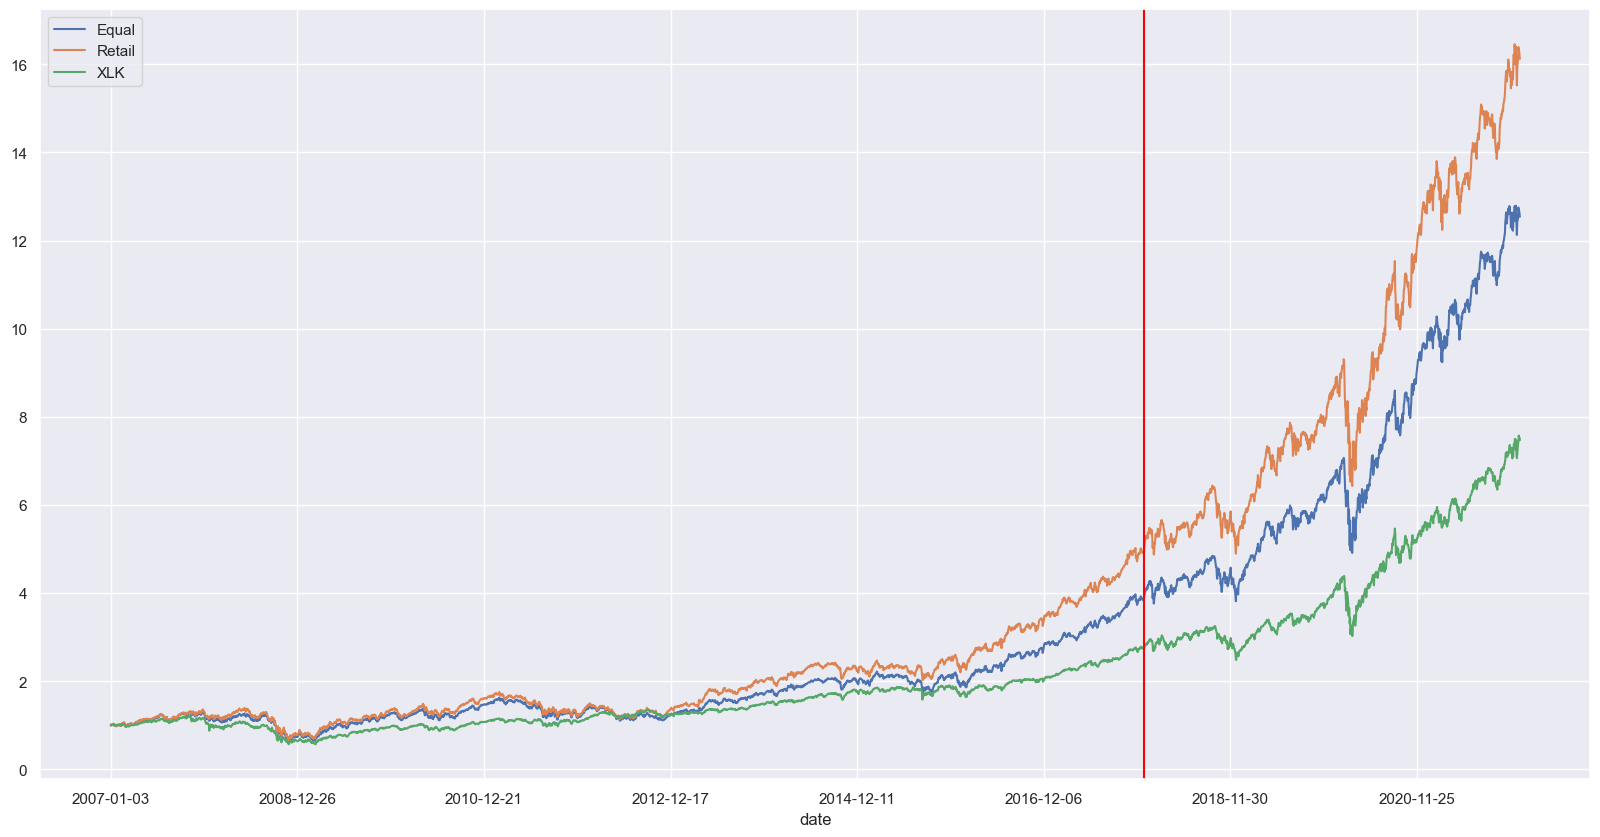

In [40]:
fig, ax = plt.subplots()
dates = data['date'].unique()

# Equal
equal_cum_ret = pd.DataFrame({'date': dates, 'ret': equal_asset_memory}) 
equal_cum_ret['ret'] = equal_cum_ret['ret'] / equal_cum_ret['ret'].loc[0]
ax = equal_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Equal")

# # Mean Variance
# mean_var_cum_ret['date'] = selected_cum_ret['date'].unique()
# ax = mean_var_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Mean Var")

# Retail
retail_cum_ret = pd.DataFrame({'date': dates, 'ret': retail_asset_memory}) 
retail_cum_ret['ret'] = retail_cum_ret['ret'] / retail_cum_ret['ret'].loc[0]
ax = retail_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Retail")

# XLK
ax = yf_xlk.plot(ax=ax, kind='line', x='date', y='ret', label="XLK")

ax.axvline(x=np.where(dates == MID_DATE)[0][0], color = 'red')
plt.show()

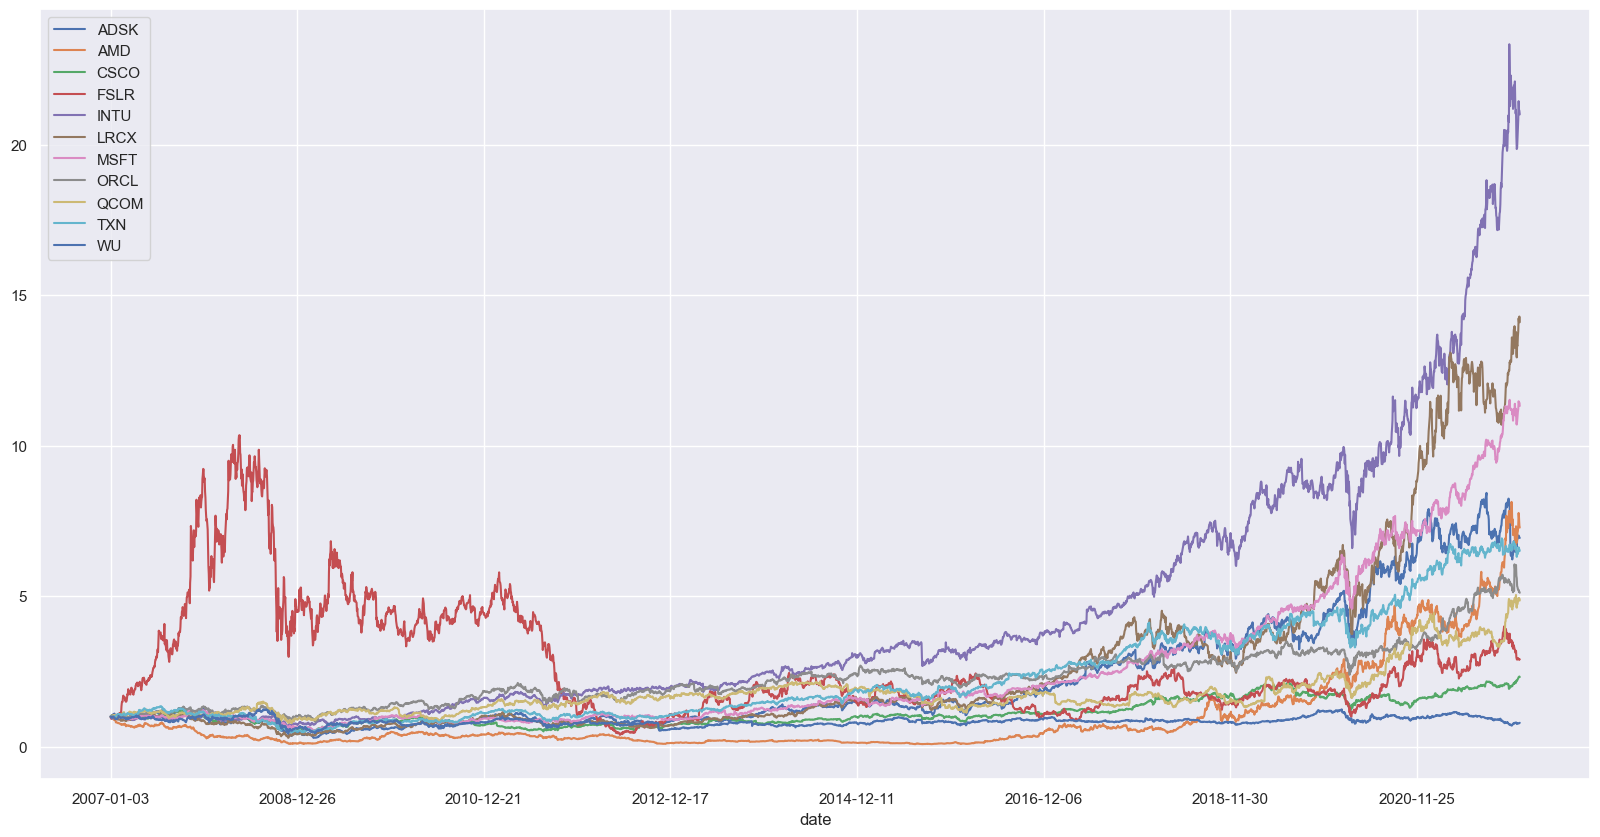

In [41]:
fig, ax = plt.subplots()

# 个股
for key, grp in selected_cum_ret.groupby(['tic']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='open', label=key)
    
plt.show()